# Support Vector Machine Linear classifier 

Here we implement a linear classified for CIFAR-10 dataset http://www.cs.toronto.edu/~kriz/cifar.html
Since it's a simple linear modelwe try to implement is ourself without relying on well-developed libraries like `PyTorch` or `TensorFlow`. 

In [1]:
# standart inputs
import matplotlib.pyplot as plt
import numpy as np

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


%config InlineBackend.figure_format = 'retina'

## Here we get the dataset
We download and extract the CIFAR-10 dataset.
No need to understand the following code.

In [2]:
import os
import requests
import tarfile
import sys

dataset_url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
dataset_folder = "cifar-10"

if not os.path.exists(dataset_folder):
    filename = os.path.basename(dataset_url)
    # here we load the dataset from the url
    with open(filename, "wb") as f:
        with requests.get(dataset_url, allow_redirects=True, stream=True) as response:
            total_length = response.headers.get('content-length')
            if total_length is None: # no content length header
                f.write(response.content)
            else:
                dl = 0
                total_length = int(total_length)
                for data in response.iter_content(chunk_size=4*4096):
                    dl += len(data)
                    f.write(data)
                    done = int(50 * dl / total_length)
                    sys.stdout.write("\r Download in progress: [%s%d%%%s]" % ('/' * done, done*2,' ' * (50-done)) )    
                    sys.stdout.flush()
        
    # here we 'untar' it
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()#path=dataset_folder+'/.')
    os.rename(tar.getnames()[0], dataset_folder)
    tar.close()
    
    #here we delete the .tarball
    os.remove(filename)

## Loading the data
So far no need to understand the following, but keep in mind that sometimes loading the data also take some effort. And this case is far from worst scenarios.

In [3]:
import time

# The data is split in 6 batches (including the testing one). We merge them all together.

dataset = {}

for batch in range(6):
    if batch != 5:
        filename = 'data_batch_%d' %(batch+1)
    else:
        filename = 'test_batch'
    ds_batch = np.load('%s/%s' %(dataset_folder, filename),
                       allow_pickle=True, encoding='latin1')

    for key in ['labels', 'data']:
        if key not in dataset:
            dataset[key] = ds_batch[key]
            dataset[key] = np.array(dataset[key])
        else:
            dataset[key] = np.concatenate((dataset[key], np.array(ds_batch[key])))

dataset['data'] = dataset['data'].reshape(dataset['data'].shape[0], 3, 32, 32).transpose(0,2,3,1).astype("float")

# normalize to 1
dataset['data'] /= 255.

In [4]:
dataset['labels'].shape, dataset['data'].shape

((60000,), (60000, 32, 32, 3))

In [5]:
# the labels are stored in numeric format
# we can use this dictionary to decode the labels

labels = {
    0: 'airplane',
    1: 'auto',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

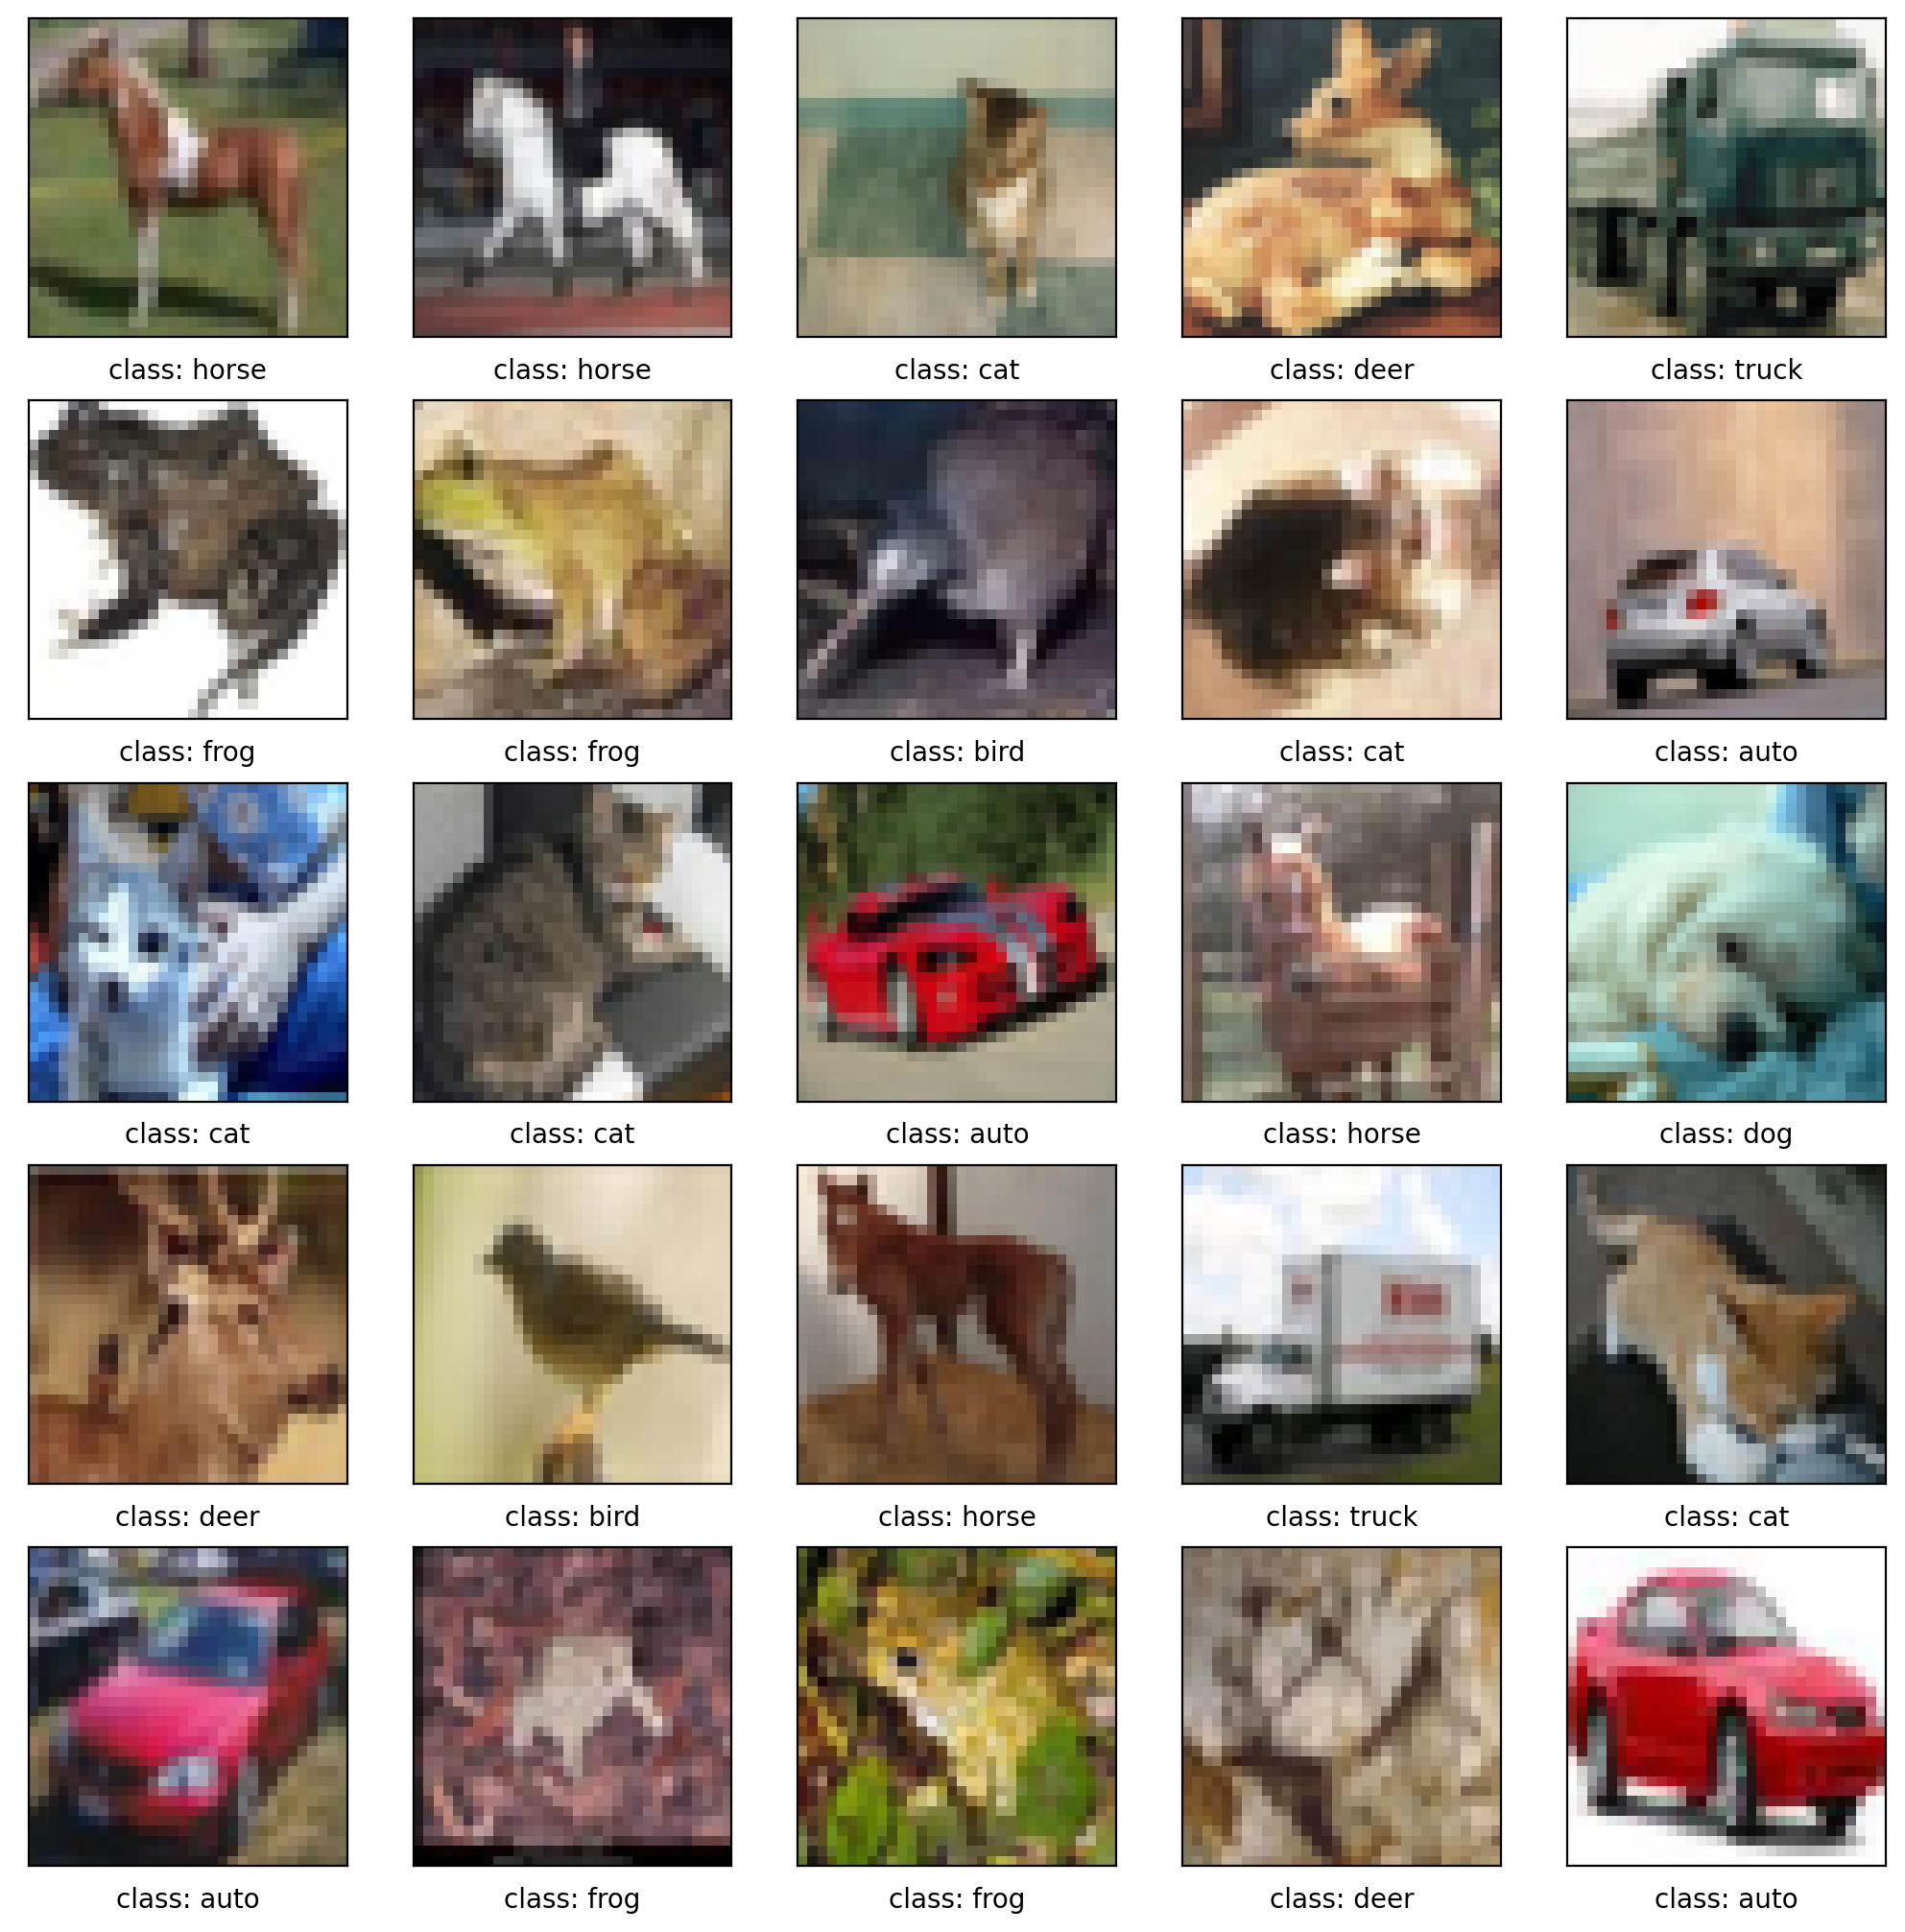

In [6]:
def plot_random_images(ds, n_images):
    # guess the size of the grid    
    size = np.sqrt(n_images)
    if size**2 != n_images:
        size += 1
    size = int(size)
    
    #initiate the figure size
    plt.figure(figsize=(2.5*size,2.5*size))
    
    # plot the images 
    for i in range(n_images):
        plt.subplot(size, size, i+1)
        
        # get a random image        
        rand_ind = np.random.randint(0,len(ds['labels']))
        
        plt.imshow(ds['data'][rand_ind])
        label_ind = ds['labels'][rand_ind]
        label = labels[label_ind]
        xlabel = "class: {0}".format(label)
        
        # show the classes as the label on the x-axis.
        plt.xlabel(xlabel)
    
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    return

plot_random_images(dataset, 25)

In [7]:
# split the dataset into training and testing
def split_data(data, test_ratio):
    data_len = len(data['data'])
    shuffled_indices = np.random.permutation(data_len)
    test_set_size = int(data_len * test_ratio)
    
    # use proper amount of elements
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    data_train = {}
    data_test = {}
    for key in data:
        data_train[key] = data[key][train_indices]
        data_test[key] = data[key][test_indices]
    return data_train, data_test

# here we use 1/10 of data for testing 
train, test = split_data(dataset, 0.1)

# and we take 1/10 of training data for validation
train, validate = split_data(train, 0.1)

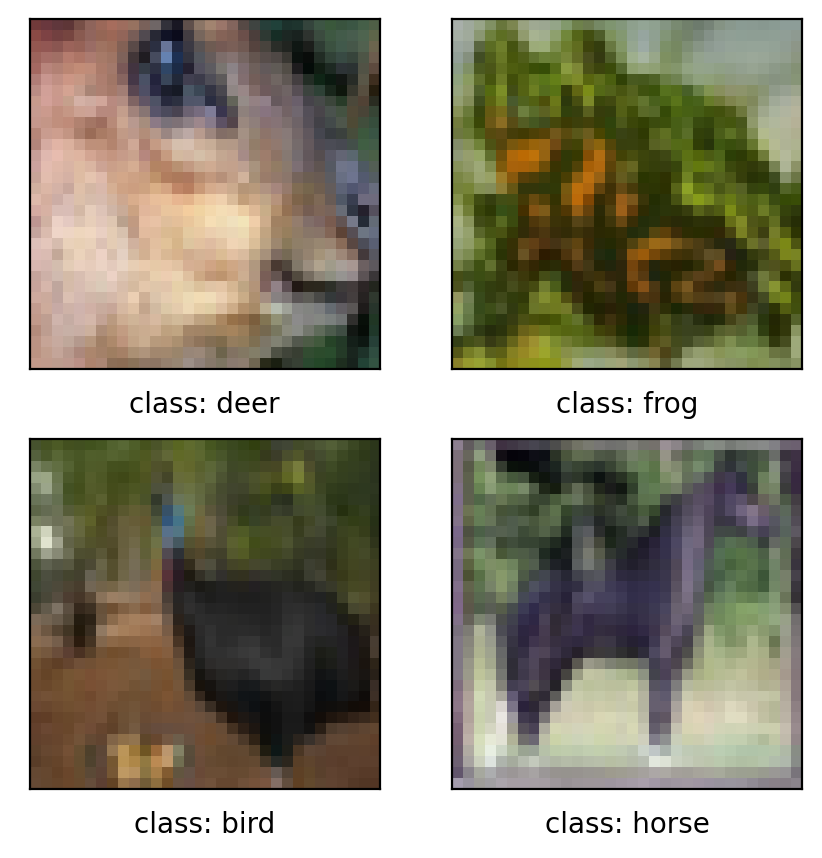

In [8]:
#here we check train images

plot_random_images(train, 4)

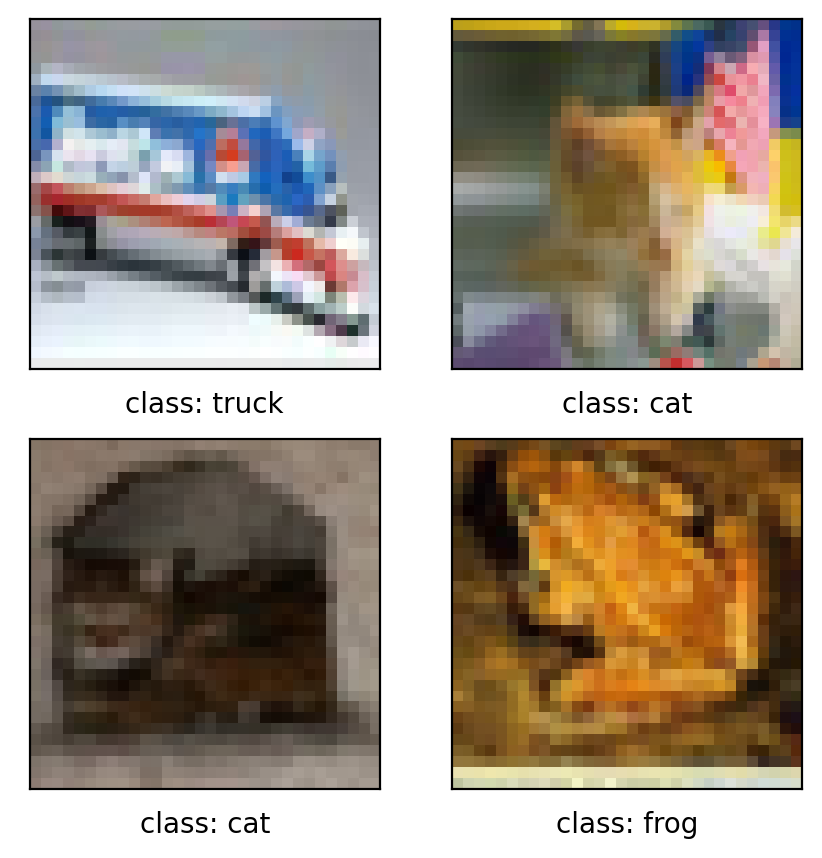

In [9]:
#here we check test images
plot_random_images(test, 4)

In [11]:
x = {'train' : train['data'], 'test' : test['data'], 'validate' : validate['data']}
y = {'train' : train['labels'], 'test' : test['labels'], 'validate' : validate['labels']}

for key in x:
    print(key, 'sample has shape', x[key].shape)

train sample has shape (48600, 32, 32, 3)
test sample has shape (6000, 32, 32, 3)
validate sample has shape (5400, 32, 32, 3)


## Usual preprocessing
as a part of usual preprocessing of data it is useful to substract the mean and normalize the data.
The data is already normalized, hence only the mean should be substracted.

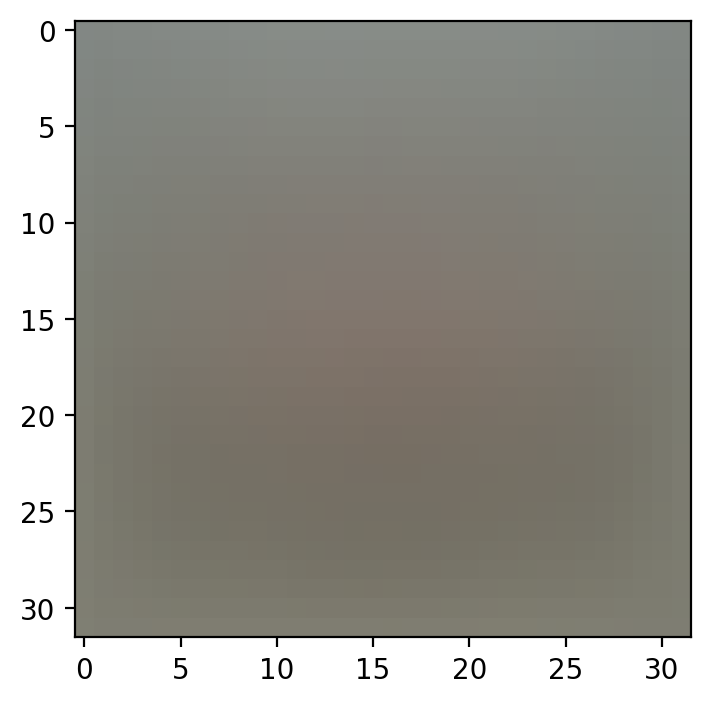

In [12]:
# here we visualize the mean
mean_image = np.mean(x['train'], axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image)
plt.show()

In [13]:
# ... and substract it from the data
for sample in x:
    x[sample] = x[sample] - mean_image

In [14]:
# now we flatten the data
for sample in x:
    # here we keep the first dimension of the sample (number of images in the sample)
    # and flatten the rest 32x32x3 to be 3072
    # -1 here is a dummy value that specifies that the rest indices should be flattened
    x[sample] = x[sample].reshape(x[sample].shape[0], -1)

## Bias vector trick
The bias vector $\vec b$ in <br>

<center>$\hat W \vec x + \vec b = \vec y$ </center>  <br>
can be incorporated in $\hat W$ by modifying the vector $\vec x$ <br>
<center> $\vec x ^\prime = (x_0,\, x_1,\, ..., x_{3072}, 1)$ </center>  <br>
hence
$$
\hat W ^\prime = \begin{pmatrix}
W_{1}^1 & ... & W_{3072}^1 & b^1\\
... & ... & ... & ... \\
W_{1}^10 & ... & W_{3072}^10 & b^{10}\\
\end{pmatrix}
$$
 and 
<center> $ \hat W^\prime \vec x^\prime = \vec y$ </center> 

In [15]:
for sample in x:
    x[sample] = np.hstack([x[sample], np.ones((x[sample].shape[0], 1))])
    print(sample, x[sample].shape)

train (48600, 3073)
test (6000, 3073)
validate (5400, 3073)


## SVM Classifier

Now we implement the svm loss and gradient. It's implemented in file **SVM/linear_svm.py**

In [115]:
# Evaluate the naive implementation of the loss we provided for you:
from SVM.linear_SVM import LinearSVM
import time

model = LinearSVM()

In [116]:
tic = time.time()
loss_log = model.train(x['train'], y['train'], n_epochs=500,
                             validate=True, x_val=x['validate'], y_val=y['validate'],
                             use_numpy=False, log_period=50, reg_type=1)
toc = time.time()
print('loss: %e computed in %fs' % (loss_log[0], toc - tic))

iteration 0 / 500: loss 8.992339
validation accuracy 0.20
iteration 50 / 500: loss 6.098498
validation accuracy 0.28
iteration 100 / 500: loss 5.499045
validation accuracy 0.32
iteration 150 / 500: loss 5.644827
validation accuracy 0.33
iteration 200 / 500: loss 5.479554
validation accuracy 0.34
iteration 250 / 500: loss 4.977066
validation accuracy 0.35
iteration 300 / 500: loss 5.150146
validation accuracy 0.35
iteration 350 / 500: loss 5.073001
validation accuracy 0.35
iteration 400 / 500: loss 4.948501
validation accuracy 0.35
iteration 450 / 500: loss 4.793104
validation accuracy 0.36
loss: 8.992339e+00 computed in 10.113137s


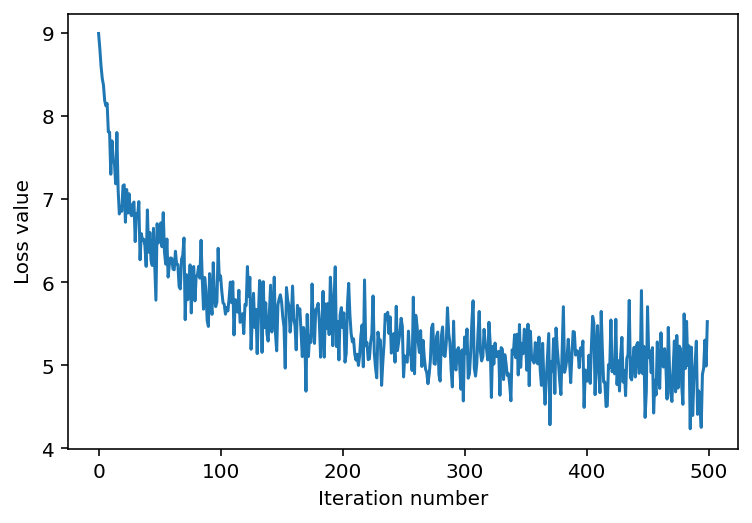

In [110]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_log)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [24]:
y_pred = model.predict(x['test'])

test_accuracy = np.mean(y['test'] == y_pred)

print("SVM linear classifier accuracy is %.2f%%" %(test_accuracy*100))

SVM linear classifier accuracy is 36.20%


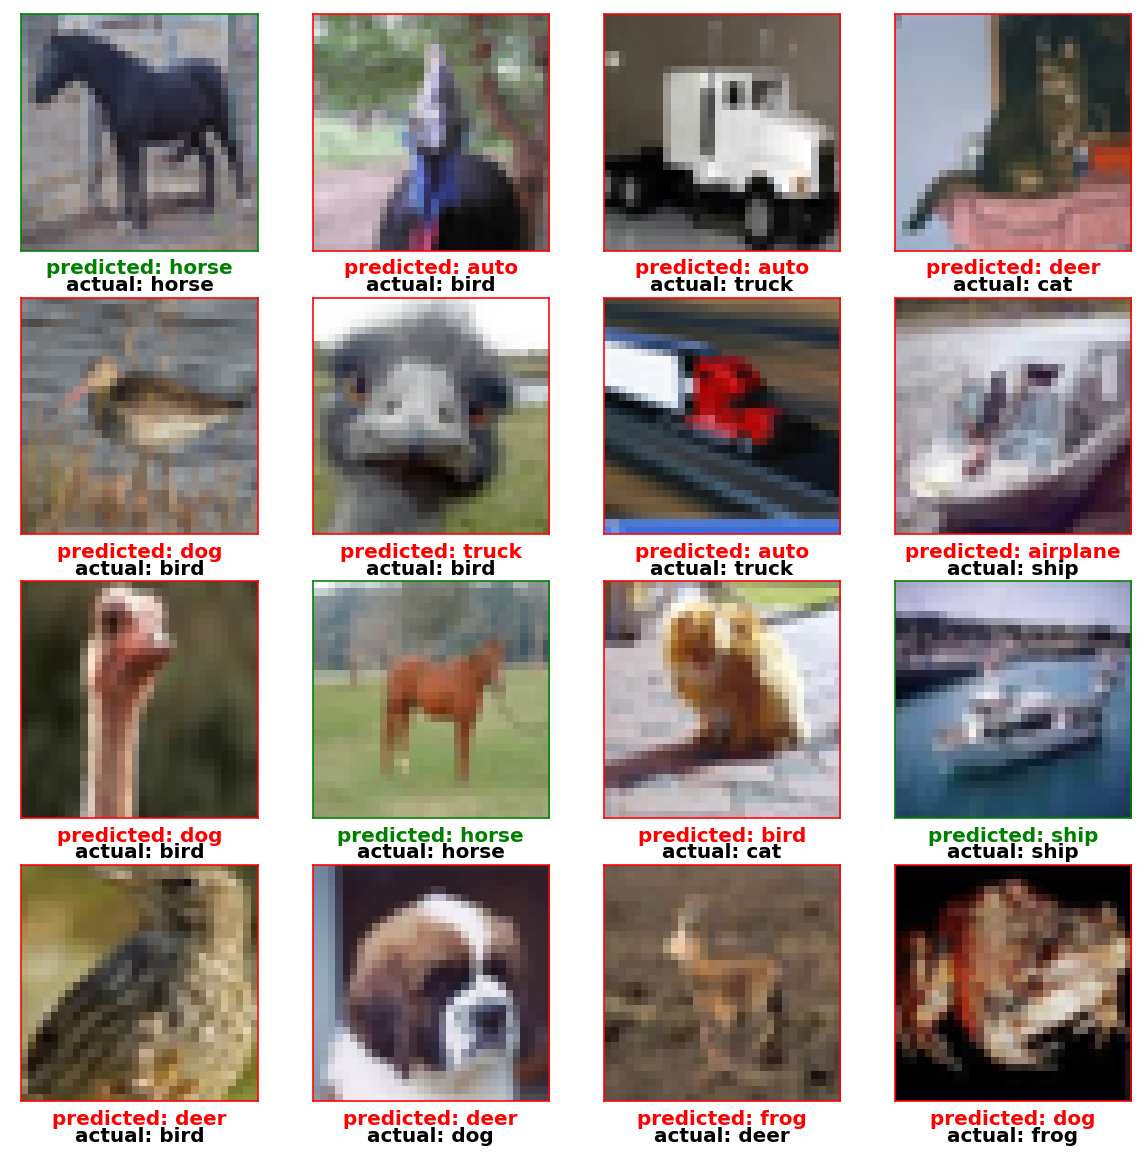

In [25]:
def plot_predictions(x,y, n_images, model):
    y_pred = model.predict(x[:n_images])
    
    # guess the size of the grid    
    size = np.sqrt(n_images)
    if size**2 != n_images:
        size += 1
    size = int(size)
    
    #initiate the figure size
    plt.figure(figsize=(2.5*size,2.5*size))
    
    # plot the images 
    for i in range(n_images):
        ax = plt.subplot(size, size, i+1)
        
        # get image
        img = x[i][:-1].reshape(32,32,3) + mean_image
        plt.imshow(img)
        label_ind = y[i]
        label_ind_pred = y_pred[i]
        label = labels[label_ind]
        label_pred = labels[label_ind_pred]
        c = "green" if label_pred == label else "red"
        plt.text(0.5, -0.1, "predicted: {0}".format(label_pred), color=c,
                ha='center', transform = ax.transAxes, weight='bold')
        plt.text(0.5, -0.17, "actual: {0}".format(label), color='black',
                ha='center', transform = ax.transAxes, weight='bold')
        
        plt.setp(ax.spines.values(), color=c)
        
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    return

plot_predictions(x['test'], y['test'], 16,model)

## Tasks:
1. try to modify the regularization to be L1 :
replace $\sum_{i,j} W_{i,j} W_{i,j}$ with $\sum_{i,j} |W_{i,j}|$
2. try to implement the SoftMax Classifier
so the<br>
$L_i= -log(P(Y=y_i|X=x_i)),~P(Y=k|X=x_i)=\frac{exp(s_k)}{\sum_j exp(s_j)}$,<br>
where $y_i$ is the correct label for the $i$-th imagge.

## Softmax classifier

In [197]:
# Evaluate the naive implementation of the loss we provided for you:
from SVM.softmax_linear_SVM import SoftMaxLinearSVM

model = SoftMaxLinearSVM()

In [198]:
tic = time.time()
loss_log = model.train(x['train'], y['train'], n_epochs=100,
                             validate=True, x_val=x['validate'], y_val=y['validate'],
                             use_numpy=True, log_period=20, batch_size=10000, learning_rate=1e-2)#, reg=1e2)
toc = time.time()
print('loss: %e computed in %fs' % (loss_log[0], toc - tic))

iteration 0 / 100: loss 2.302591
validation accuracy 0.20
iteration 20 / 100: loss 2.150775
validation accuracy 0.26
iteration 40 / 100: loss 2.081732
validation accuracy 0.28
iteration 60 / 100: loss 2.040381
validation accuracy 0.29
iteration 80 / 100: loss 2.015367
validation accuracy 0.30
loss: 2.302591e+00 computed in 6.904963s


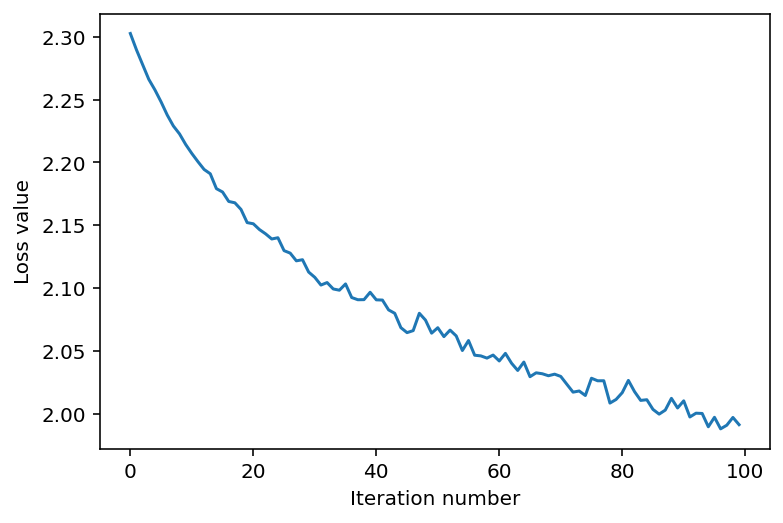

In [105]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_log)
plt.xlabel('Iteration number')
plt.ylabel('Loss vaxlue')
plt.show()

# Git instructions
Link to the repo: https://github.com/amotornenko/linear_SVM
- Activate the conda environment:<br>
`$ conda activate MLlectures`
- navigate to the folder with the linear SVM:<br>
`$ cd linear_SVM`
- or checkout to a new folder by:<br>
`git clone https://github.com/amotornenko/linear_SVM.git`
- hide our local changes from `git`:<br>
`$ git stash`
- check at which branch are we:
`$ git branch`
-- should be `classroom`, if not then<br>
`$ git fetch`
-- list remote branches:<br>
`$ git branch -v -a`
switch to `classroom`:<br>
-- `$ git switch classroom`
-pull the latest version from the branch:<br>
 `$ git pull`

## k-nearest neighbours
![](knn.png)
[WIki:](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

Requires a definition of distance $d(\vec x_1,\vec x_2)$ between objects $\vec x_1$ and  $\vec x_2$, one can use simple $L^2$ measure:
$d(\vec x_1,\vec x_2) = \sqrt{(\vec x_1 - \vec x_2)^2}$

In [212]:
class kNearestNeighbors(object):
    
    #constductor
    def __init__(self):
        pass
    
    # provide the data to the model
    def train(self, x, y):
        self.X_train = x
        self.y_train = y
    
    # method to compute the L2 distance
    def compute_distances(self, X):
        # here you have to calculate the sqrt((X - X_train)^2)
        dists = ...
        
        return dists
    
    # make a prediction based on the neighbors
    def predict(self, X, k=1):
        dists = self.compute_distances(X)
        
        # iterate over the number of samples for the prediction        
        for i in range(X.shape[0]):
            
            #sort the distances and get indices of these samples
            sorted_dist = np.argsort(dists[i])
            
            # get k closest neighbors 
            closest_y = self.y_train[sorted_dist[0:k]]
            
            #figure out what label is the most popular among neighbors
            y_pred[i]= (np.argmax(np.bincount(closest_y)))

        return y_pred
    
    
    def show_kNeighbors(self, X, Y, k=1):
        """
        plots k nearest and k furthes samples in the data
        """
        
        # calculate distances
        dists = self.compute_distances(X)
        
        # order distances by length
        sorted_dist = np.argsort(dists[0])
        
        # get k closest [images, their labels, distances]
        closest = [self.X_train[sorted_dist[0:k]], self.y_train[sorted_dist[0:k]], dists[0][sorted_dist[0:k]]]
        
        # get k furthest [images, their labels, distances]
        farthest = [self.X_train[sorted_dist[-k:]],self.y_train[sorted_dist[-k:]], dists[0][sorted_dist[-k:]]]
        
        # prepare figure
        plt.figure(figsize=(2.5*(k+1),2.5*2))
    
        # plot the images 
        # (sorry, here's a bit crowded code)
        
        # iterate over (k+1)*2 subplots:
        # - first subplot is the image used for the prediction
        # - k plots for closest  neighbors
        # - empty plot
        # - k plots for furthest neighbors
        for i in range((k+1)*2):
            # - empty plot
            if (i-1) == k:
                continue
                
            # select appropriate subplot
            ax = plt.subplot(2, k+1, i+1)
            
            # - first subplot is the image used for the prediction
            if i == 0: 
                img = X[0][:-1].reshape(32,32,3) + mean_image
                label_ind = Y[0]
                
                label = labels[label_ind]
                plt.text(0.5, -0.1, "correct class: {0}".format(label),
                        ha='center', transform = ax.transAxes, weight='bold')
                
                # predict label
                label_pred_ind = self.predict(X,k)[0]
                label_pred = labels[label_pred_ind]
                plt.text(0.5, -0.2, "predicted: {0}".format(label_pred),
                        ha='center', transform = ax.transAxes, weight='bold')
                
            # - k plots for closest  neighbors
            # - k plots for furthest neighbors
            else:
                closestImage = (i-1 < k)
                
                # get image
                if closestImage:
                    data = closest
                else:
                    data = farthest
                    
                img = data[0][i%k][:-1].reshape(32,32,3) + mean_image
                label_ind = data[1][i%k]
                dist = data[2][i%k]
                    
                label = labels[label_ind]
                c = "green" if closestImage else "red"
                plt.text(0.5, -0.1, "{0}, d={1:.2f}".format(label,dist), color=c,
                        ha='center', transform = ax.transAxes, weight='bold')
                plt.setp(ax.spines.values(), color=c)
                   
            plt.imshow(img)
            
            plt.xticks([])
            plt.yticks([])

        plt.show()
        return

In [213]:
model = kNearestNeighbors()
model.train(x['train'],y['train'])

tic = time.time()
y_pred = model.predict(x['test'],k=10)
acc = np.mean(y_pred == y['test'])
toc = time.time()

print('Accuracy: %.1f %% computed in %fs' % (acc*100, toc - tic))

Accuracy: 34.0 % computed in 25.800141s


Lets make a prediction for a random image and see what are the nearest neighbors

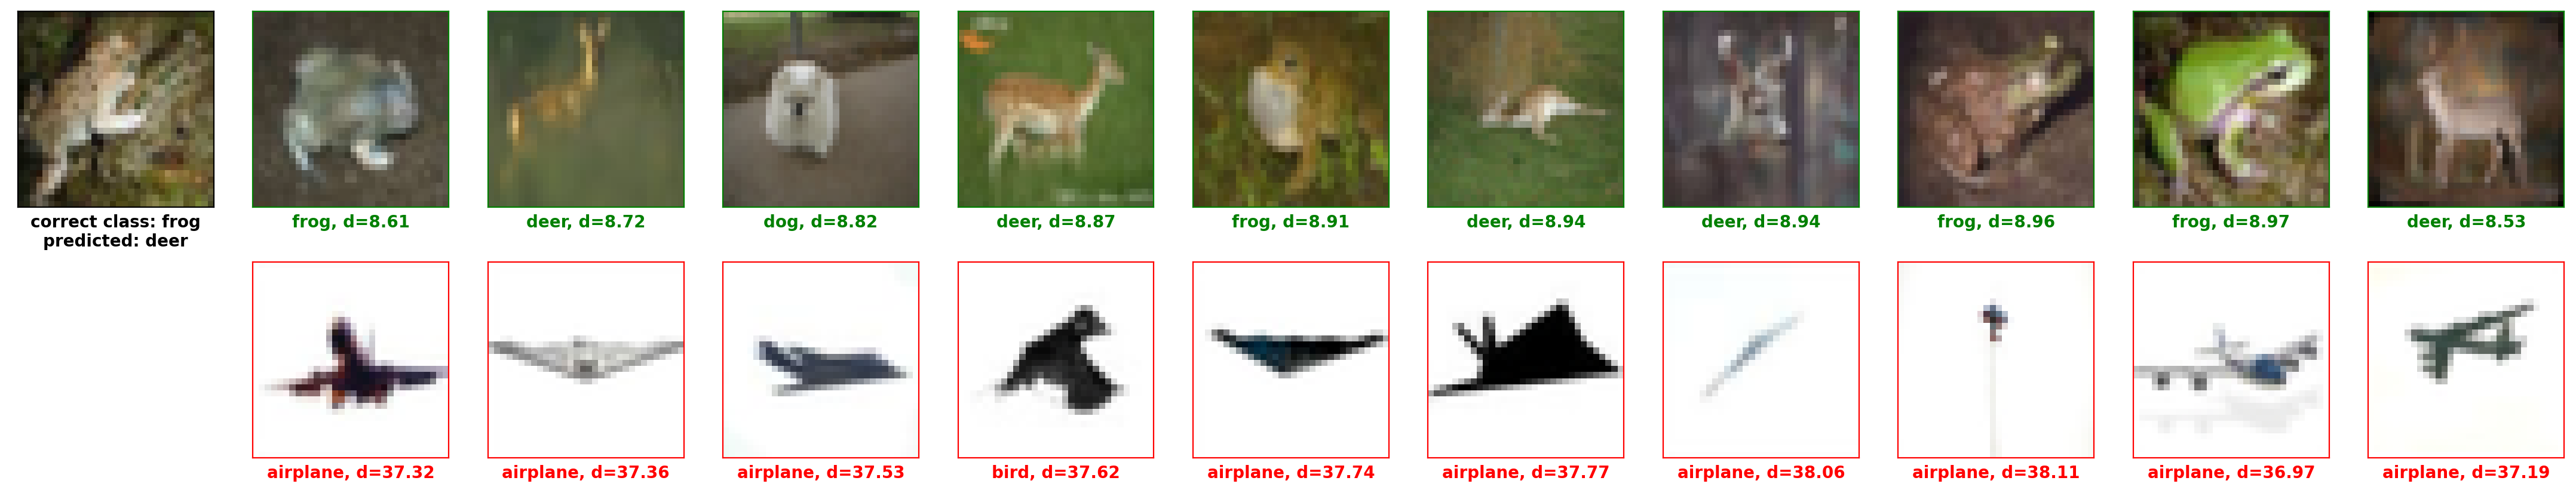

In [214]:
# Get index for a random image from the testing sample
ind = np.random.randint(x['test'].shape[0])

model.show_kNeighbors(x['test'][ind:ind+1],y['test'][ind:ind+1],k=10)